In [169]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import calendar

import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.cm import ScalarMappable
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size' : 18})

# About
__Author:__ Pat McCornack  
__Date:__ 03/22/25  
__About:__ This notebook was created while cleaning up the repository - it aggregates and updates old EDA notebooks. The purpose is to 1) understand weather conditions at stations across the island, and 2) understand the relationship between fog and other variables. 

# Functions

In [232]:
def single_plot(data, month, year, ax, min_fog, max_fog):
    """
    Called by plot_hourly_heatmap. Creates component of temporal heatmap.
    """

    data = data[(data["time (PST)"].dt.year == year) & (data["time (PST)"].dt.month == month)]

    hour = data["time (PST)"].dt.hour
    day = data["time (PST)"].dt.day
    fog = data["fog tips"]
    fog = fog.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)

    
    ax.pcolormesh(xgrid, ygrid, fog, cmap="magma", vmin=min_fog, vmax=max_fog)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Set larger font sizes for tick labels
    ax.tick_params(axis='both', labelsize=12)  # Adjust as needed for tick labels

    # Remove all spines
    ax.set_frame_on(False)

def plot_hourly_heatmap(df, year, min_fog, max_fog):
    """
    Creates temporal heatmap to illustrate fog event timing. 
    """
    fig, axes = plt.subplots(1, 5, figsize=(10, 7), sharey=True)

    # Plot Figure
    for j, month in enumerate(range(5, 10)):
        single_plot(df, month, year, axes[j], min_fog, max_fog)
        axes[j].set(ylabel='Hour',
                    xlabel='Day')
        axes[j].set_title(calendar.month_name[month], fontsize=17)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)

    # Create Legend
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.025])
    norm = mc.Normalize(min_fog, max_fog)

    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="magma"), 
        cax=cbar_ax, # Pass the new axis
        orientation = "horizontal"
    )
    cb.ax.xaxis.set_tick_params(size=0)

    cb.set_label("Fog Tips", size=12)
    fig.suptitle(year)
    plt.show()

def leaf_wetness_plot(fog_event, var):
    """
    Create lineplot of leaf wetness and relative humidity overlaid with bar plot of fog events. Used to study how leaf wetness
    responds to fog events. Optionally show voltage data from datalogger as lineplot. 

    Parameters
    ----------
    fog_event : pandas.DataFrame
        Dataframe of meteorological values during fog event event.
    xtick_interval : int
        Interval in hours to show xticks for
    show_voltage : boolean
        Whether to show lineplot of datalogger voltage. Used to assess whether leaf wetness behavior is caused by datalogger voltage. 

    Returns
    -------
    None
    
    """
    start_time = fog_event['time (PST)'].iloc[0]
    stop_time = fog_event['time (PST)'].iloc[-1]
    #xticks = fog_event.index[::xtick_interval]
    fig, ax = plt.subplots(figsize=(15,6))

    # Plot Leaf Wetness
    fog_event[var].plot(kind='line', label='Leaf Wetness')
    ax.set(ylabel=var,
           xlabel='Date')

    # Plot Fog
    ax2 = ax.twinx()
    fog_event['fog'].plot(kind='area', alpha=0.3, color='gray', ax=ax2,
                          label='Fog Drip')
    ax2.set_yticks([])
    ax2.grid(False)

    # Plot RH
    ax3=ax.twinx()
    fog_event['relative humidity (%)'].plot(kind='line', color='orange', alpha=0.4, ax=ax3,
                                            label='Relative Humidity')
    ax3.set(ylabel='Relative Humidity')

    #plt.xticks(ticks=xticks, rotation=90)
    plt.title(f'{fog_event['site'].unique()[0]}\n{start_time} - {stop_time}')
    plt.show()

# Read in Data

In [171]:
# Read in data
root_dir = Path().resolve().parents[1]
data_fpath = root_dir / 'data' / '02-clean' / 'combined-sites.csv'

met_df = pd.read_csv(data_fpath, index_col=0)
met_df['time (PST)'] = pd.to_datetime(met_df['time (PST)'])

# Subset to summer months
met_df = met_df.loc[met_df['time (PST)'].dt.month.isin([5,6,7,8,9])]

# Create categorical variable for atmospheric condition
met_df['condition'] = met_df.apply(lambda row : 'both' if row['fog'] > 0 and row['rain (mm)'] > 0
                           else 'fog' if row['fog'] > 0
                           else 'rain' if row['rain (mm)'] > 0
                           else 'clear', axis=1)

## Weather Conditions for Overlapping Data
Much of the data received from Chris Still overlaps temporally, allowing us a window to compare site microclimates. Here we compare standard met variables across these sties. 


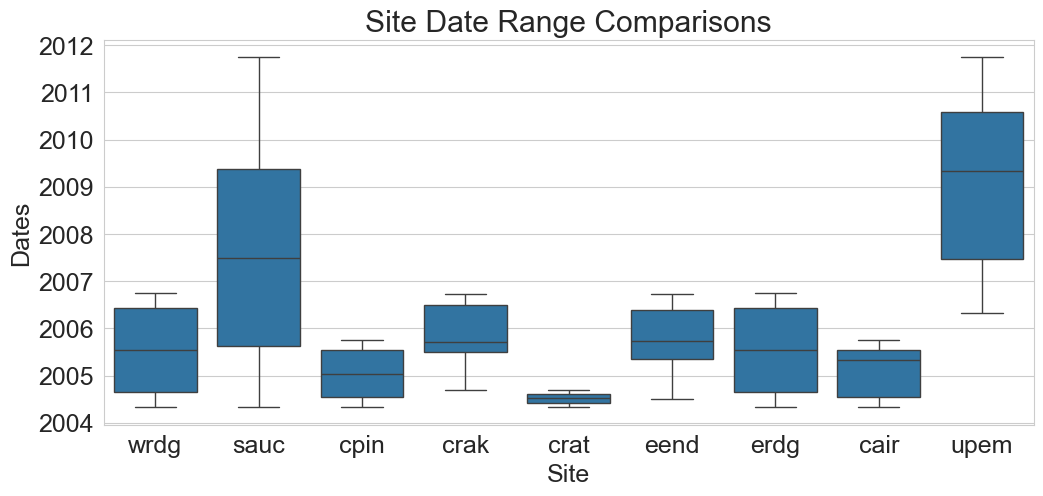

In [172]:
# Remove SMO2 - it has no overlap
df = met_df.loc[met_df['site'] != 'pozo-smo2']

# Check distributions of dates
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df,
            y='time (PST)',
            x='site')
ax.set(title='Site Date Range Comparisons',
       xlabel='Site',
       ylabel='Dates')
plt.show()

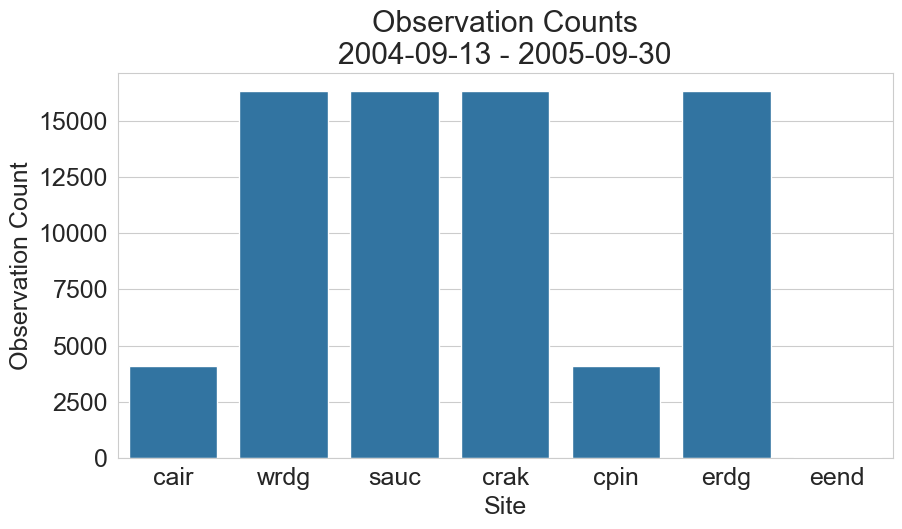

In [173]:
# Subset to common timeframes

# Remove sites with little overlap
df = met_df.loc[~met_df['site'].isin(['pozo-smo2', 'crat', 'upem'])]
sites = list(df['site'].unique())

# Subset to common dateranges
minimums = []
maximums = []
for site in sites:
    site_df = df.loc[df['site'] == site]
    minimums.append(site_df['time (PST)'].min())
    maximums.append(site_df['time (PST)'].max())

df = df.loc[df['time (PST)'] > np.max(minimums)]
df = df.loc[df['time (PST)'] < np.min(maximums)]

# Plot counts of observations - Note that Cair and Cpin are hourly
site_counts = df.groupby('site')['fog'].count()
site_order = ['cair', 'wrdg', 'sauc', 'crak', 'cpin', 'erdg', 'eend']  # Ordered West -> East

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(site_counts, order=site_order, ax=ax)
plt.xticks(site_order)
ax.set(title=f'Observation Counts\n{df['time (PST)'].min().date()} - {df['time (PST)'].max().date()}',
       xlabel='Site',
       ylabel='Observation Count')

plt.show()

Observation Counts site
cair    4084
cpin    4084
crak    4085
erdg    4085
sauc    4085
wrdg    4085
Name: fog_bool, dtype: int64


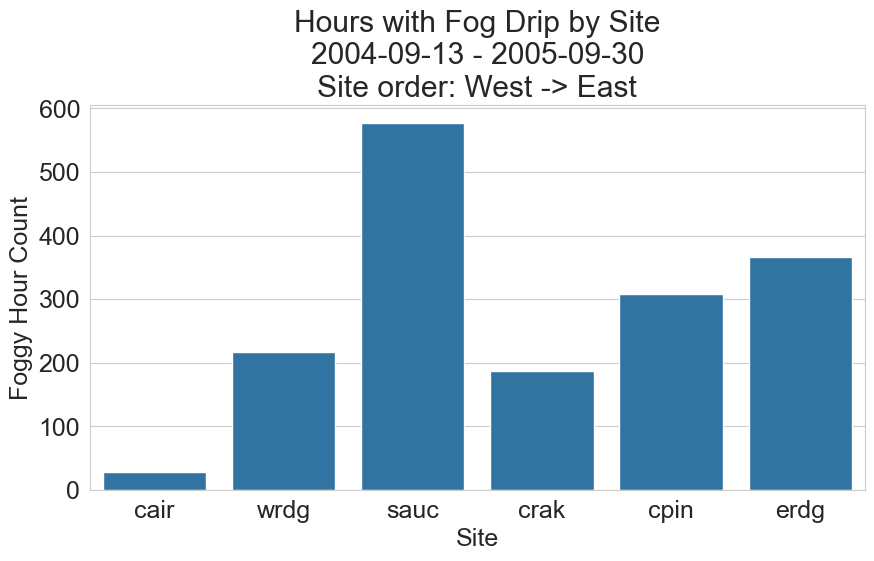

In [174]:
df = df.loc[df['site'] != 'eend']  # Eend has very few observations

## Plot Hourly Fog Frequencies

# Aggregate data to hourly
df_hr = df.set_index(['site', 'time (PST)'])[['fog']]
df_hr = df_hr.groupby(['site', pd.Grouper(freq='h', level='time (PST)')])['fog'].sum().reset_index()

# Get whether fog occurred that hour
df_hr['fog_bool'] = df_hr['fog'].apply(lambda x: 1 if x > 0 else 0)

# Get count of foggy hours
site_counts = df_hr.groupby('site')['fog_bool'].count()
fog_freq = df_hr.groupby('site')['fog_bool'].sum()

# Check that site counts are the same 
print('Observation Counts', site_counts)

# Plot fog frequencies
fig, ax = plt.subplots(figsize=(10,5))
site_order_subset = site_order.copy()
site_order_subset.remove('eend')
sns.barplot(fog_freq, order=site_order_subset, ax=ax)
ax.set(title=f'Hours with Fog Drip by Site\n{df['time (PST)'].min().date()} - {df['time (PST)'].max().date()}\nSite order: West -> East',
       xlabel='Site',
       ylabel='Foggy Hour Count')
plt.show()

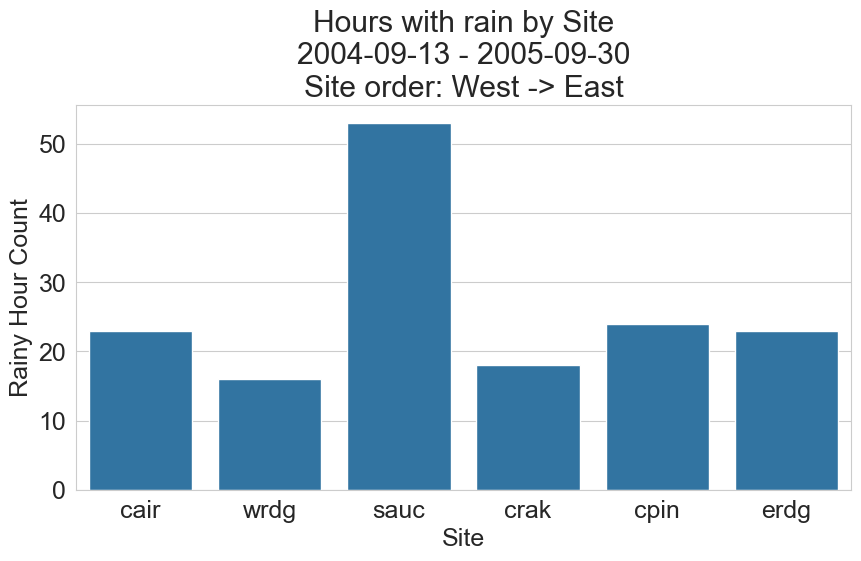

In [175]:
## Plot Hourly rain (mm)
# Aggregate data to hourly
df_hr = df.set_index(['site', 'time (PST)'])[['rain (mm)']]
df_hr = df_hr.groupby(['site', pd.Grouper(freq='h', level='time (PST)')])['rain (mm)'].sum().reset_index()

# Get whether rain (mm) occurred that hour
df_hr['rain_bool'] = df_hr['rain (mm)'].apply(lambda x: 1 if x > 0 else 0)

# Get count of rain (mm)gy hours
site_counts = df_hr.groupby('site')['rain_bool'].count()
rain_freq = df_hr.groupby('site')['rain_bool'].sum()

# Check that site counts are the same 
site_counts

# Plot rain (mm) frequencies
fig, ax = plt.subplots(figsize=(10,5))
site_order_subset = site_order.copy()
site_order_subset.remove('eend')
sns.barplot(rain_freq, order=site_order_subset, ax=ax)
ax.set(title=f'Hours with rain by Site\n{df['time (PST)'].min().date()} - {df['time (PST)'].max().date()}\nSite order: West -> East',
       xlabel='Site',
       ylabel='Rainy Hour Count')

plt.show()

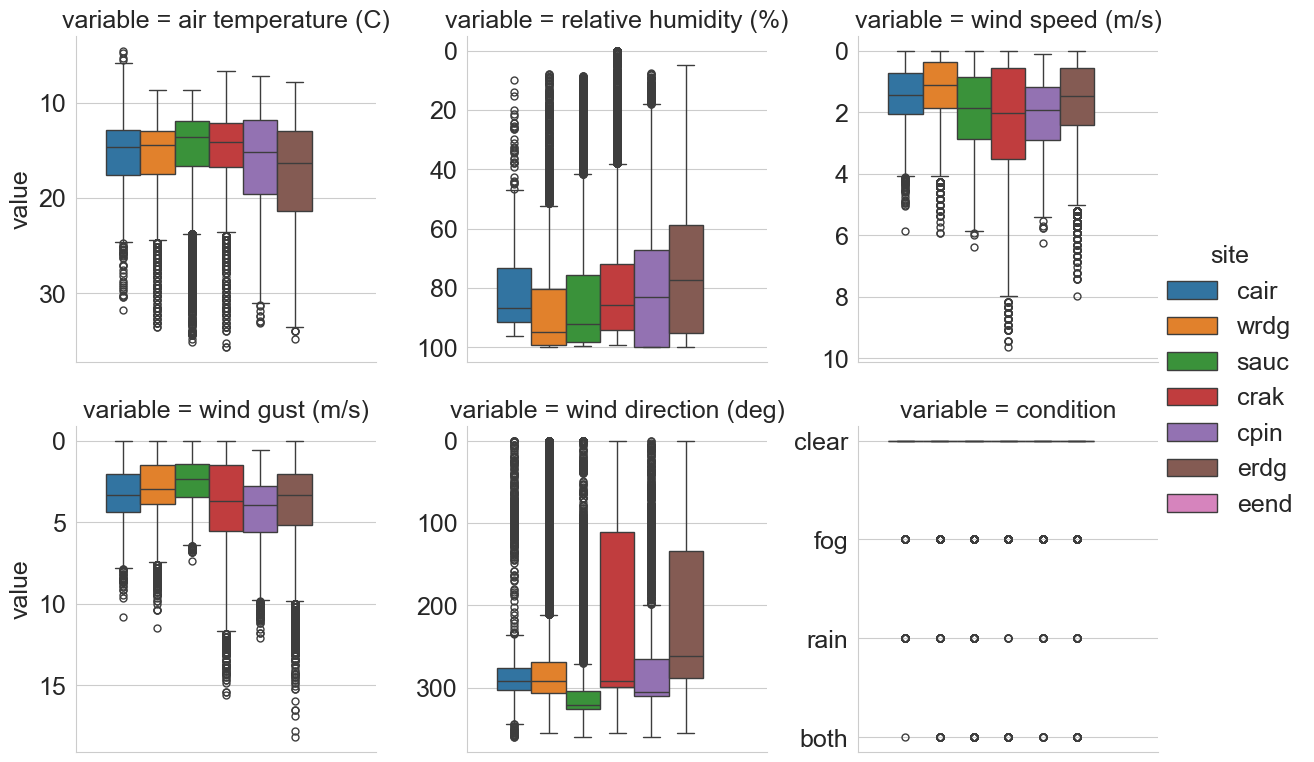

In [176]:
# Plot Met distributions
# Drop any column with NAs - only want common variables
df = df.dropna(axis=1)

value_cols = df.columns.drop(['site', 'fog', 'fog tips', 'rain (mm)', 'time (PST)']).tolist()
df_long = pd.melt(df.drop('fog', axis=1), id_vars=['site', 'time (PST)'], value_vars=value_cols)
sns.catplot(df_long, kind='box', col='variable', y='value', hue='site', 
            sharey=False, height=4, col_wrap=3, legend='full', hue_order=site_order)
plt.show()

## Weather Conditions Using Entire Dataset


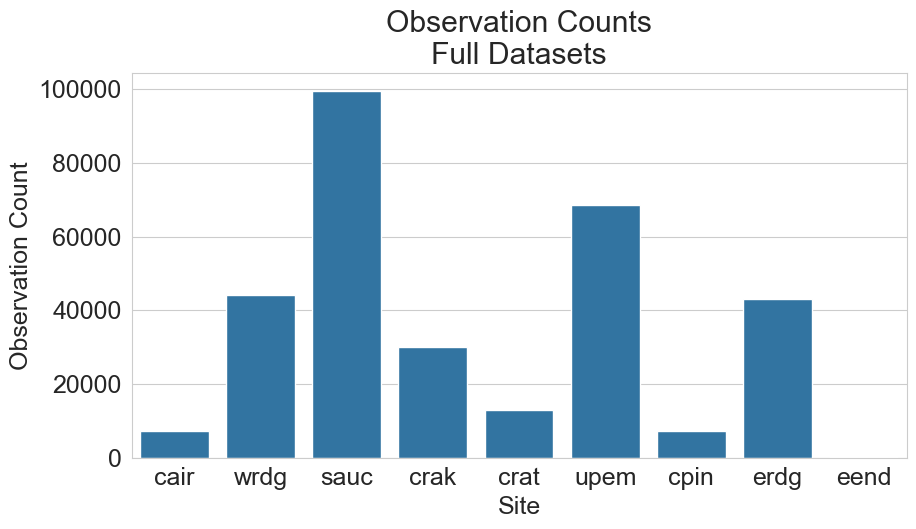

In [177]:
# Remove sites with little overlap
df = met_df.loc[~met_df['site'].isin(['pozo-smo2'])]

# Plot counts of observations - Note that Cair and Cpin are hourly
site_counts = df.groupby('site')['fog'].count()
site_order = ['cair', 'wrdg', 'sauc', 'crak', 'crat', 'upem', 'cpin', 'erdg', 'eend']  # Ordered West -> East

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(site_counts, order=site_order, ax=ax)
ax.set(title=f'Observation Counts\nFull Datasets',
       xlabel='Site',
       ylabel='Observation Count')

plt.show()

Observation Counts site
cair     7343
cpin     7344
crak     7507
crat     3253
erdg    10806
sauc    24892
upem    17131
wrdg    11016
Name: fog_bool, dtype: int64


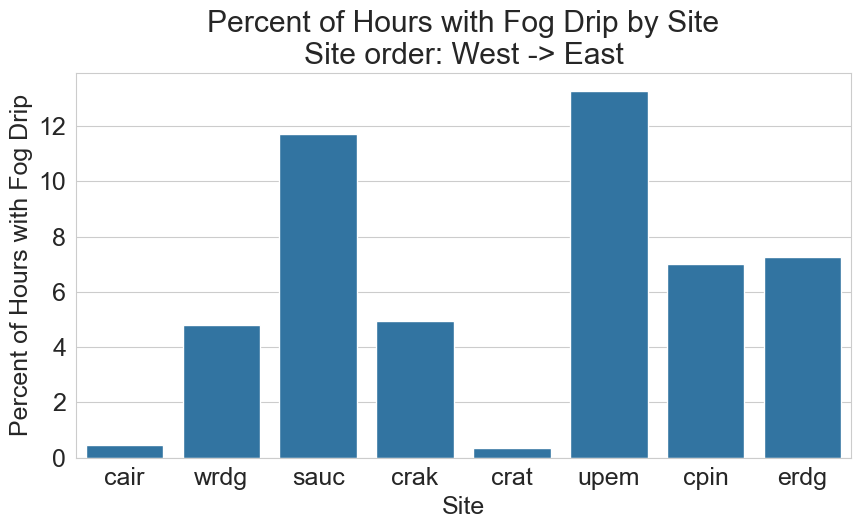

In [178]:
df = df.loc[df['site'] != 'eend']  # Eend has very few observations

## Plot Hourly Fog Frequencies

# Aggregate data to hourly
df_hr = df.set_index(['site', 'time (PST)'])[['fog']]
df_hr = df_hr.groupby(['site', pd.Grouper(freq='h', level='time (PST)')])['fog'].sum().reset_index()

# Get whether fog occurred that hour
df_hr['fog_bool'] = df_hr['fog'].apply(lambda x: 1 if x > 0 else 0)

# Get count of foggy hours
site_counts = df_hr.groupby('site')['fog_bool'].count()
fog_freq = df_hr.groupby('site')['fog_bool'].sum()
fog_freq_perc = fog_freq / site_counts * 100

# Check that site counts are the same 
print('Observation Counts', site_counts)

# Plot fog frequencies
fig, ax = plt.subplots(figsize=(10,5))
site_order_subset = site_order.copy()
site_order_subset.remove('eend')
sns.barplot(fog_freq_perc, order=site_order_subset, ax=ax)
ax.set(title=f'Percent of Hours with Fog Drip by Site\nSite order: West -> East',
       xlabel='Site',
       ylabel='Percent of Hours with Fog Drip')
plt.show()

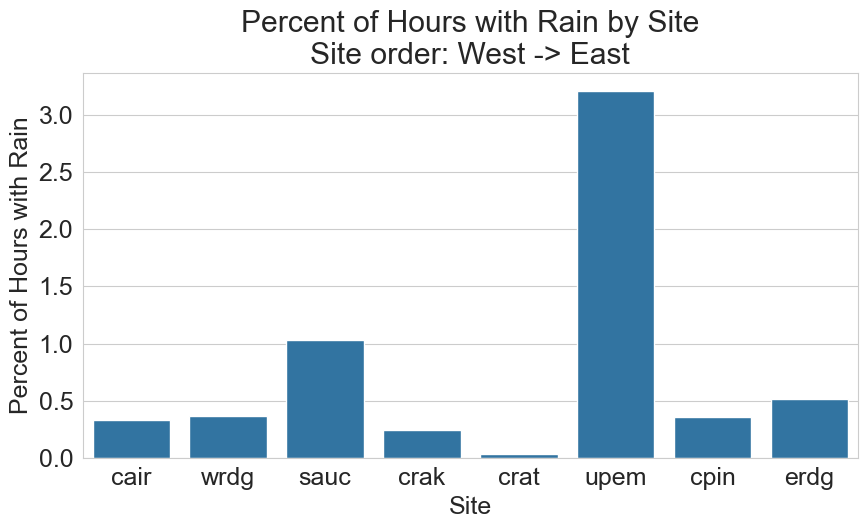

In [179]:
## Plot Hourly rain (mm)
# Aggregate data to hourly
df_hr = df.set_index(['site', 'time (PST)'])[['rain (mm)']]
df_hr = df_hr.groupby(['site', pd.Grouper(freq='h', level='time (PST)')])['rain (mm)'].sum().reset_index()

# Get whether rain (mm) occurred that hour
df_hr['rain_bool'] = df_hr['rain (mm)'].apply(lambda x: 1 if x > 0 else 0)

# Get count of rain (mm)gy hours
site_counts = df_hr.groupby('site')['rain_bool'].count()
rain_freq = df_hr.groupby('site')['rain_bool'].sum()
rain_freq_perc = rain_freq / site_counts * 100

# Check that site counts are the same 
site_counts

# Plot rain frequencies
fig, ax = plt.subplots(figsize=(10,5))
site_order_subset = site_order.copy()
site_order_subset.remove('eend')
sns.barplot(rain_freq_perc, order=site_order_subset, ax=ax)
ax.set(title=f'Percent of Hours with Rain by Site\nSite order: West -> East',
       xlabel='Site',
       ylabel='Percent of Hours with Rain')

plt.show()

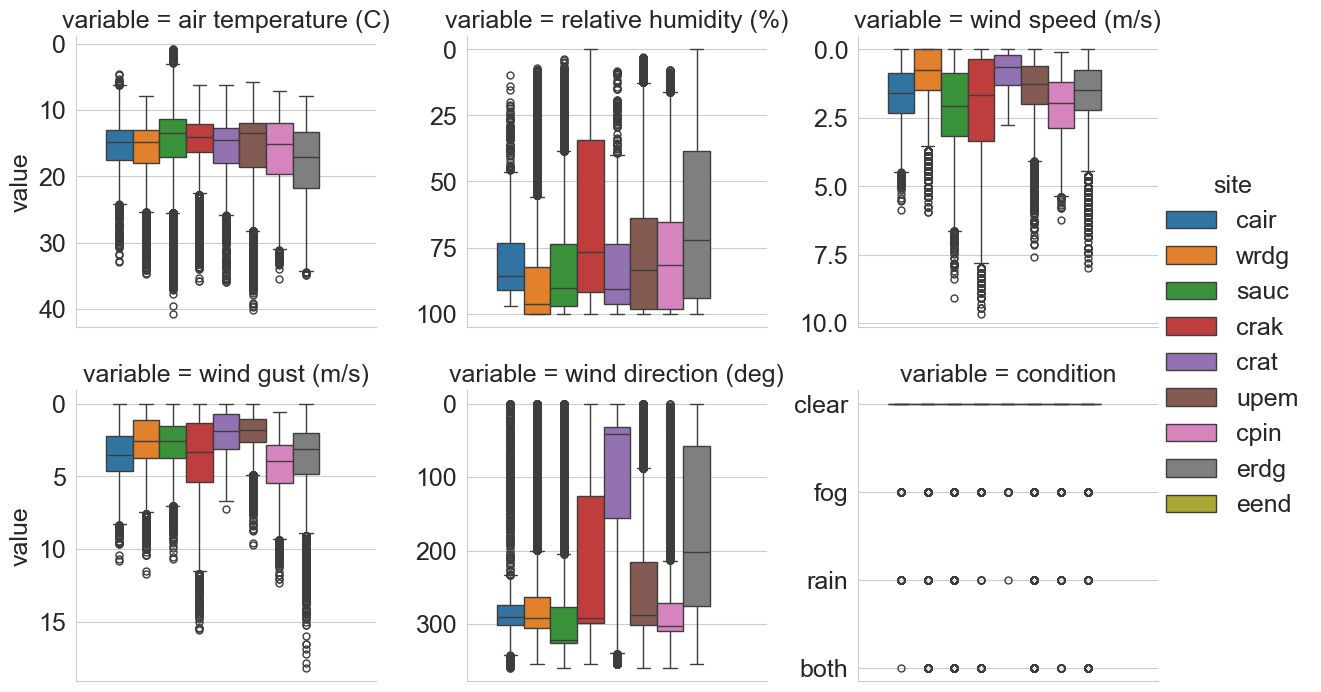

In [180]:
# Plot Met distributions
df_long = pd.melt(df.drop('fog', axis=1), id_vars=['site', 'time (PST)'], value_vars=value_cols)
sns.catplot(df_long, kind='box', col='variable', y='value', hue='site', 
            sharey=False, height=4, col_wrap=3, legend='full', hue_order=site_order)
plt.show()

# Site Fog vs. Clear Conditions
Sauces and Upem have the largest datasets, and are the foggiest sites. For these site, we look at the difference in meteorological conditions during fog vs. clear conditions. We also look at Pozo SMO2, as this is the site for which we have the most information about, and confidence in, the fog harp.

In [181]:
# Prepare the data
df = met_df.loc[met_df['site'].isin(['pozo-smo2', 'sauc', 'upem'])]
df = df.dropna(how='all', axis=1)  # Drop empty columns
df = df.drop(['solar radiation (kwm2)', 'atm pressure (mb)', 'leaf wetness (mv)'], axis=1)  # Drop cols not shared between sites

# Create condition variable to stratify by


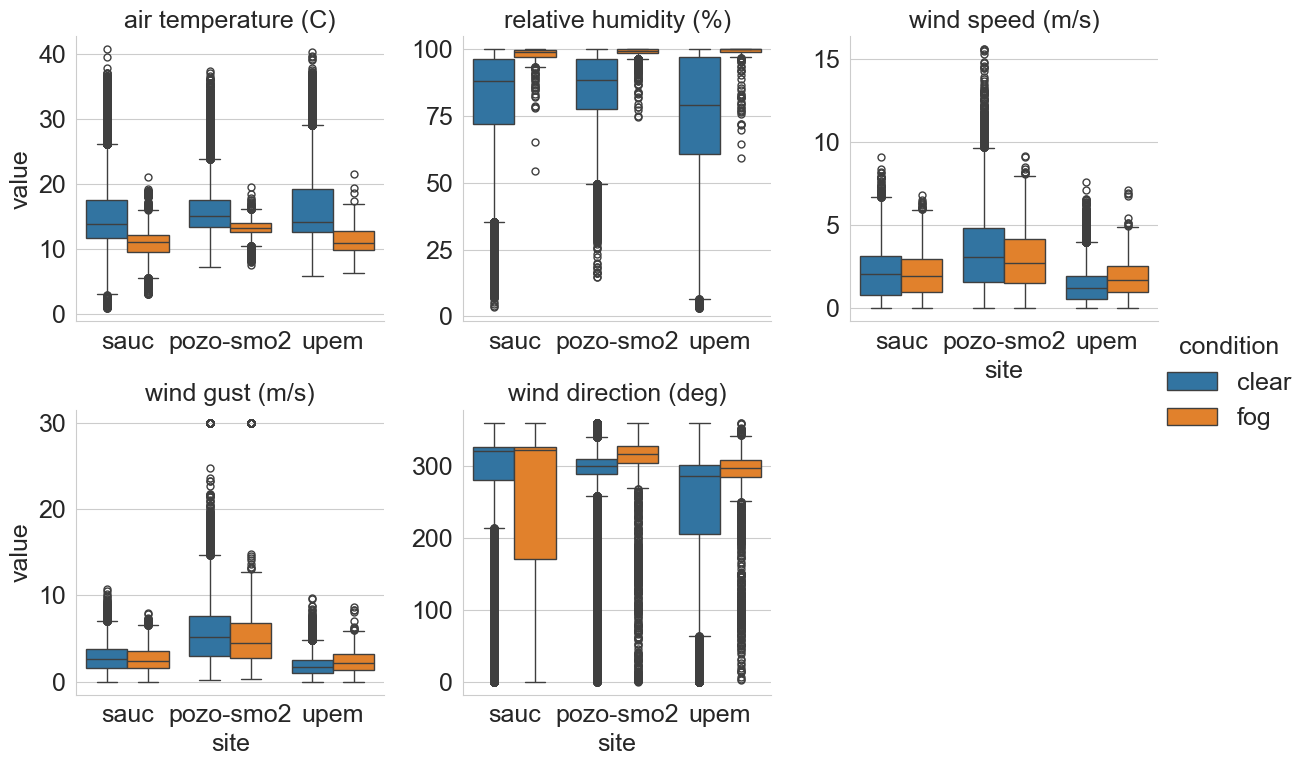

In [182]:
# Plot Met distributions
df_long = df.loc[df['condition'].isin(['fog', 'clear'])]
df_long = pd.melt(df_long, id_vars=['site', 'condition', 'time (PST)'], value_vars=value_cols)
g = sns.catplot(df_long, kind='box', col='variable', x='site', hue='condition', y='value',
            sharey=False, height=4, col_wrap=3, legend='full')
# Show x-tick labels on all subplots and rotate them
g.tick_params(axis='x', labelbottom=True)
g.set_titles('{col_name}')
plt.show()

# Fog Temporal Analyses

## Site Trends in Fog Drip
Sauces and Upem are the only sites with longer records, so check for trends over time in total hours with fog drip.

__Note that in the below plot, I think the fog harps were probably not deployed in the first year for each station.__

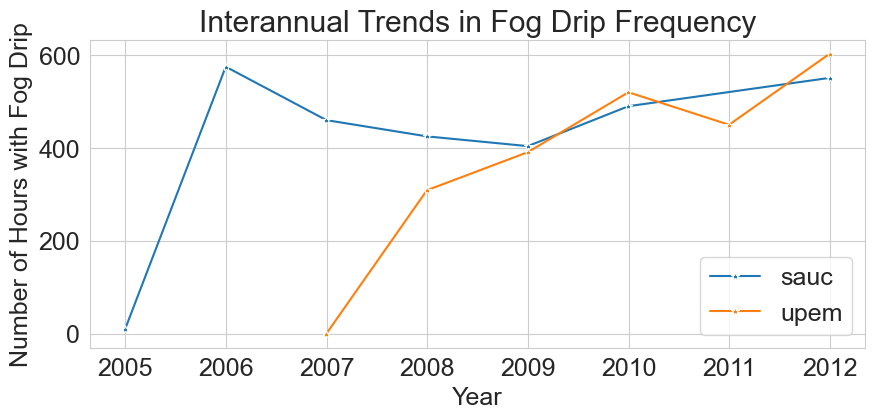

In [183]:
df = met_df.loc[met_df['site'].isin(['sauc', 'upem'])]
df_hr = df.set_index(['site', 'time (PST)'])
df_hr = df_hr.groupby(['site', pd.Grouper(freq='h', level='time (PST)')])[['fog tips']].sum()
df_hr['fog_bool'] = df_hr['fog tips'].apply(lambda x : 1 if x > 0 else 0)

df_gp = df_hr.groupby(['site', pd.Grouper(freq='YE', level='time (PST)')])[['fog_bool']].sum()
df_gp = df_gp.reset_index().rename({'fog_bool' : 'fog_hours'}, axis=1)

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=df_gp,
             x='time (PST)',
             y='fog_hours',
             hue='site',
             marker='*')
ax.set(title='Interannual Trends in Fog Drip Frequency',
       xlabel='Year',
       ylabel='Number of Hours with Fog Drip')
plt.legend(title='')
plt.show()


## Site Fog Drip Temporal Heatmaps
Heat maps for when fog drip occurs for the selected site. Change the site to look at the period of record for that site. 

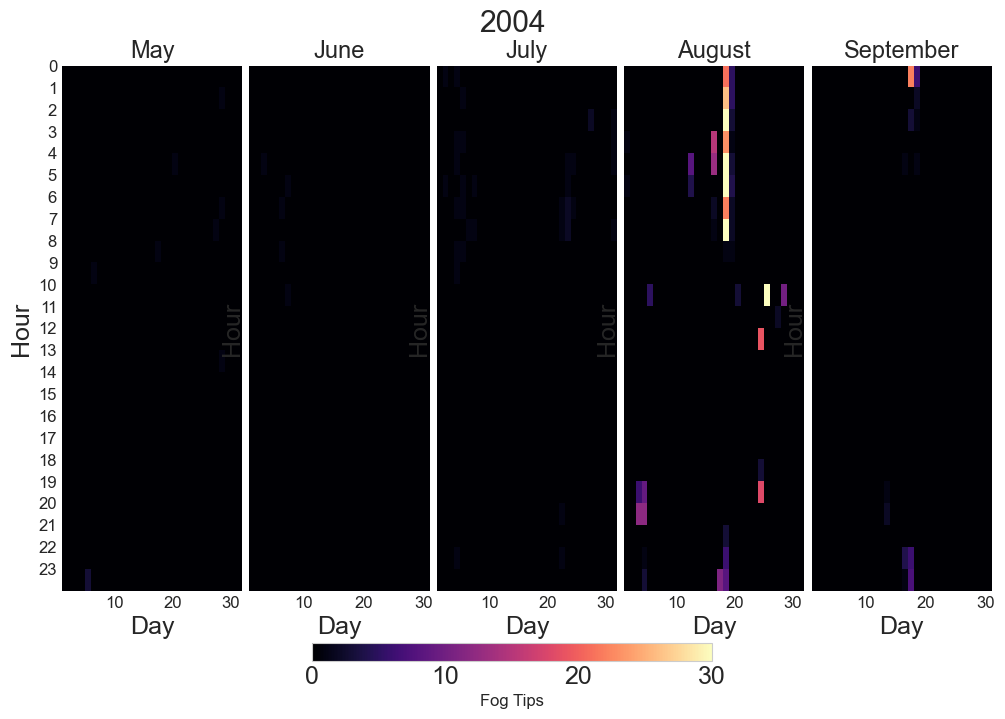

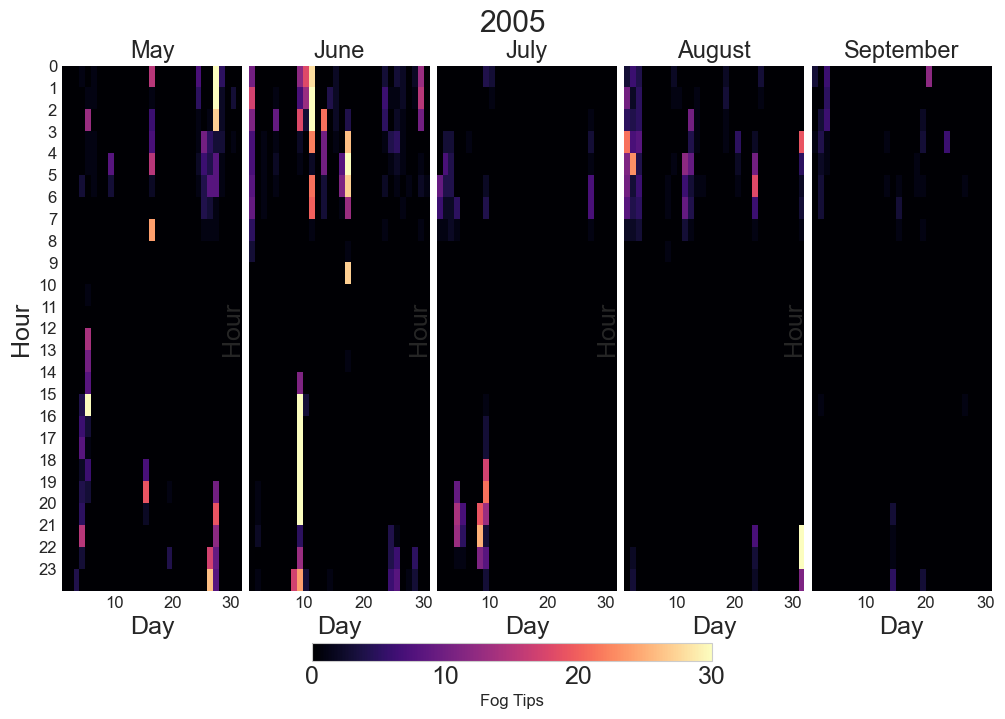

In [233]:
site = 'erdg' 
df_hourly = met_df[met_df['site'] == site].set_index('time (PST)')
df_hourly = df_hourly.loc[df_hourly['condition'] != 'both']  # Remove rain bycatch
df_hourly = df_hourly[['fog tips']].resample('h').sum().reset_index()

# Plot Heat Maps
min_fog = 0
max_fog = 30  # Chosen to highlight overall trend

# Get years to plot
min_year = df_hourly['time (PST)'].min().year
max_year = df_hourly['time (PST)'].max().year
years = np.arange(min_year, max_year).tolist()
for year in years:
    plot_hourly_heatmap(df_hourly, year, min_fog, max_fog)



# Relationships between Variables

## Fog Drip vs. Wind Speed

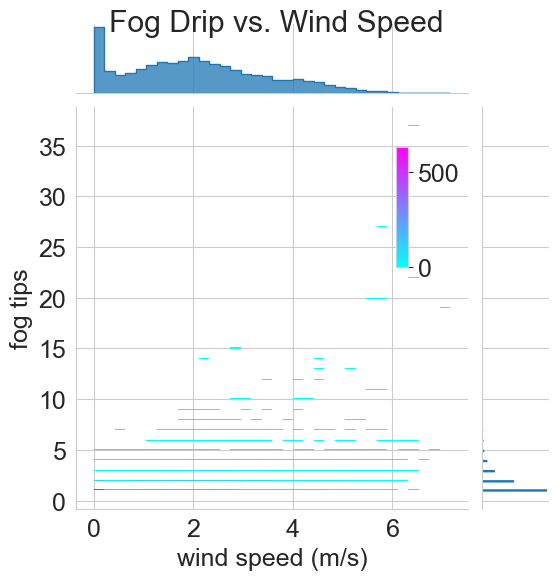

In [187]:
df = met_df.loc[met_df['site'] == 'sauc']
df = df.loc[df['fog tips'] != 0]

g = sns.JointGrid(data=df,
                  x='wind speed (m/s)',
                  y='fog tips')
cax = g.figure.add_axes([.7, .55, .02, .2])

g.plot_joint(sns.histplot,
            cmap='cool',
            cbar=True,
            cbar_ax=cax)

g.plot_marginals(sns.histplot, element='step')
plt.suptitle('Fog Drip vs. Wind Speed')
plt.show()

## Leaf Wetness
Check relationship between leaf wetness and fog. 

Upem and Sauc don't have leaf wetness. Pozo SMO2 uses different units than other sites. 

### Pozo SMO2
There is a known issue with the Pozo SMO2 leaf wetness sensor where the value initially decreases when the sensor gets wet, then rises. Per communications with Campbell Scientific, this may be due to a capacitive load caused by a tight zip tie on the sensor cable. 

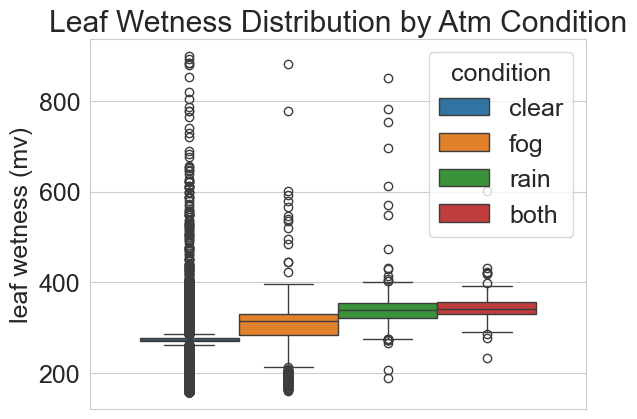

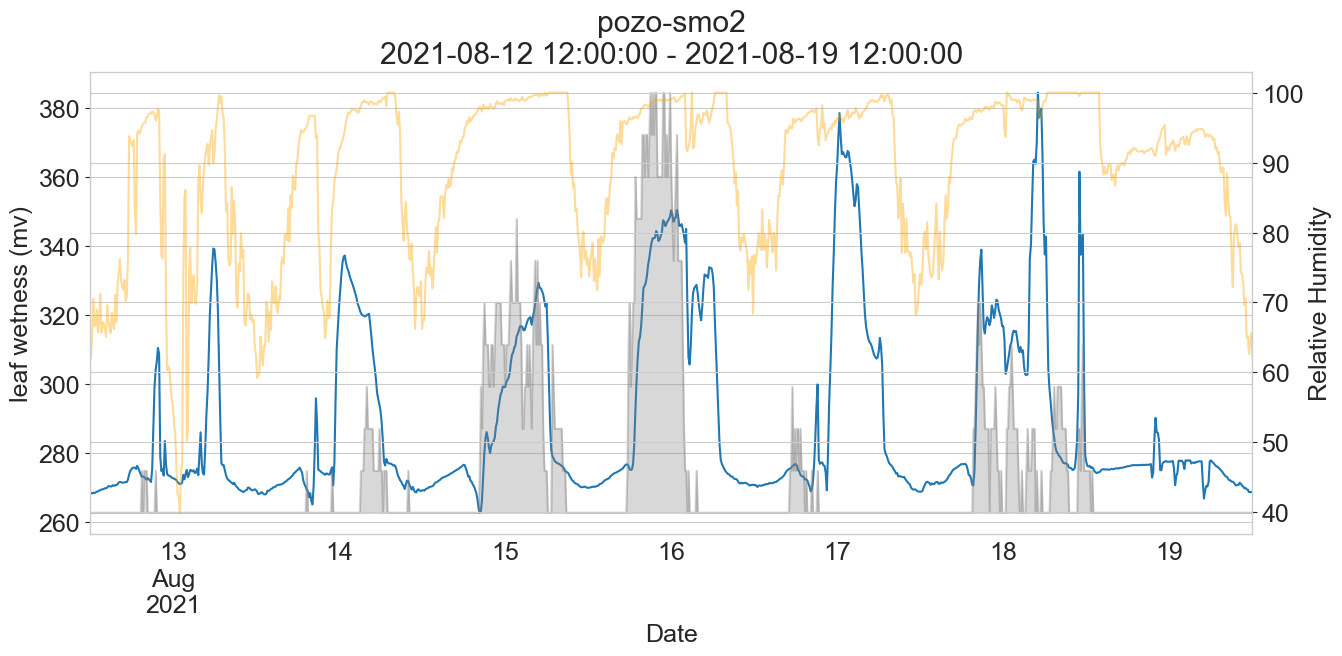

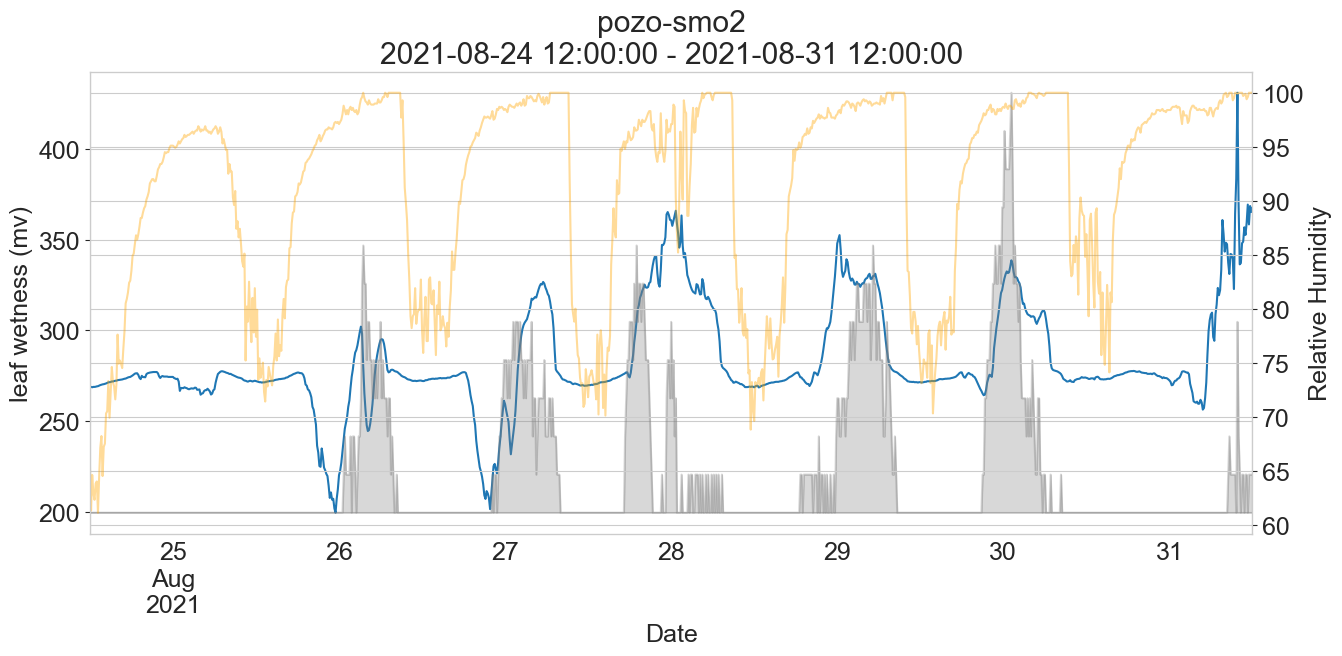

In [225]:
# Check pozo
df = met_df.loc[met_df['site'] == 'pozo-smo2']
df = df.set_index('time (PST)', drop=False)

# Leaf wetness boxplot
fig, ax = plt.subplots()
sns.boxplot(data=df,
            y='leaf wetness (mv)',
            hue='condition')
plt.title('Leaf Wetness Distribution by Atm Condition')
plt.show()

# Plot Fog Event Examples
fog_event = df['2021-08-12 12:00:00': '2021-08-19 12:00:00']
fog_event_2 = df['2021-08-24 12:00:00' : '2021-08-31 12:00:00']

leaf_wetness_plot(fog_event, var='leaf wetness (mv)')
leaf_wetness_plot(fog_event_2, var='leaf wetness (mv)')

### WRDG and ERDG
These use a different type of sensor where the value decreases when the sensor is wet. 

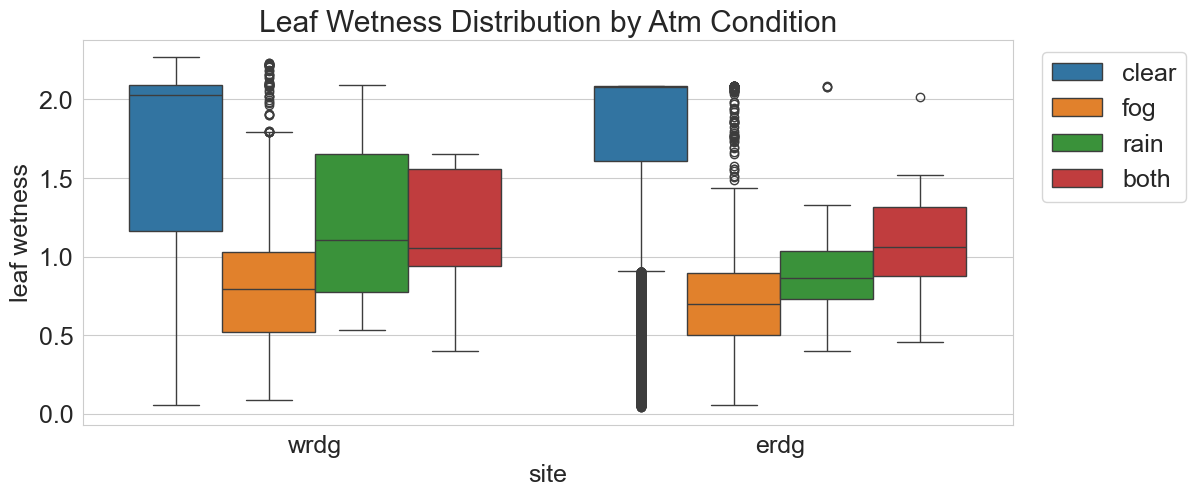

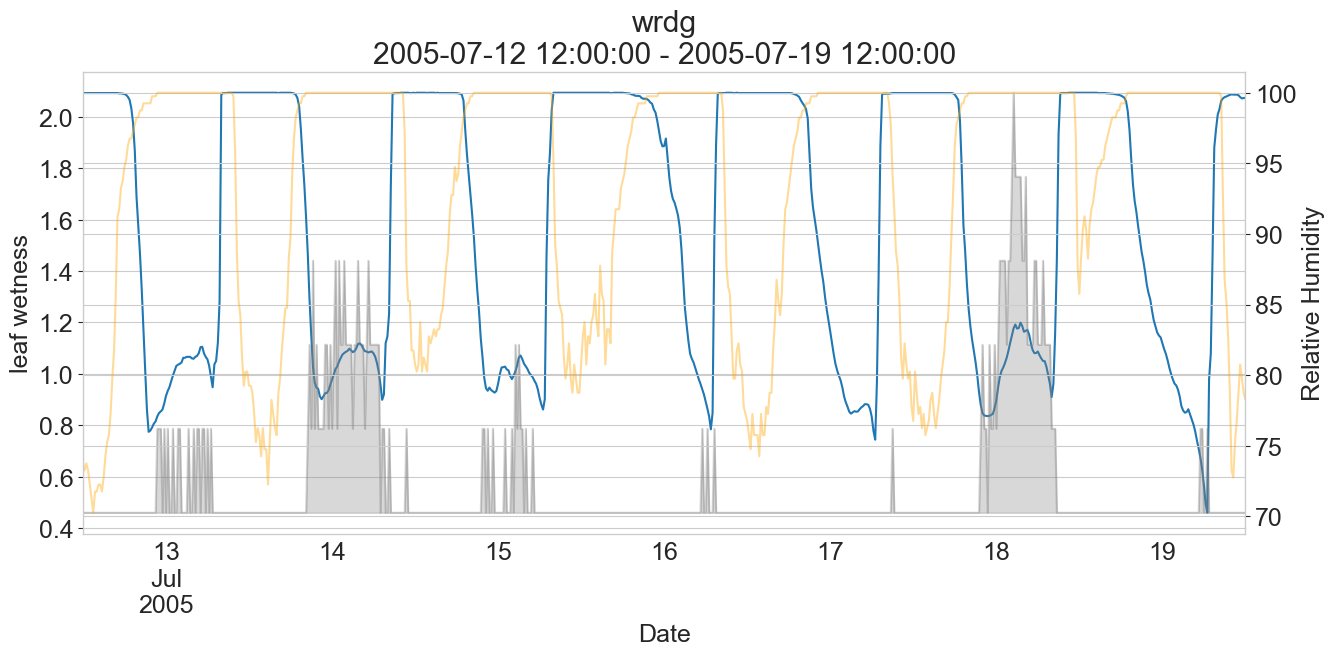

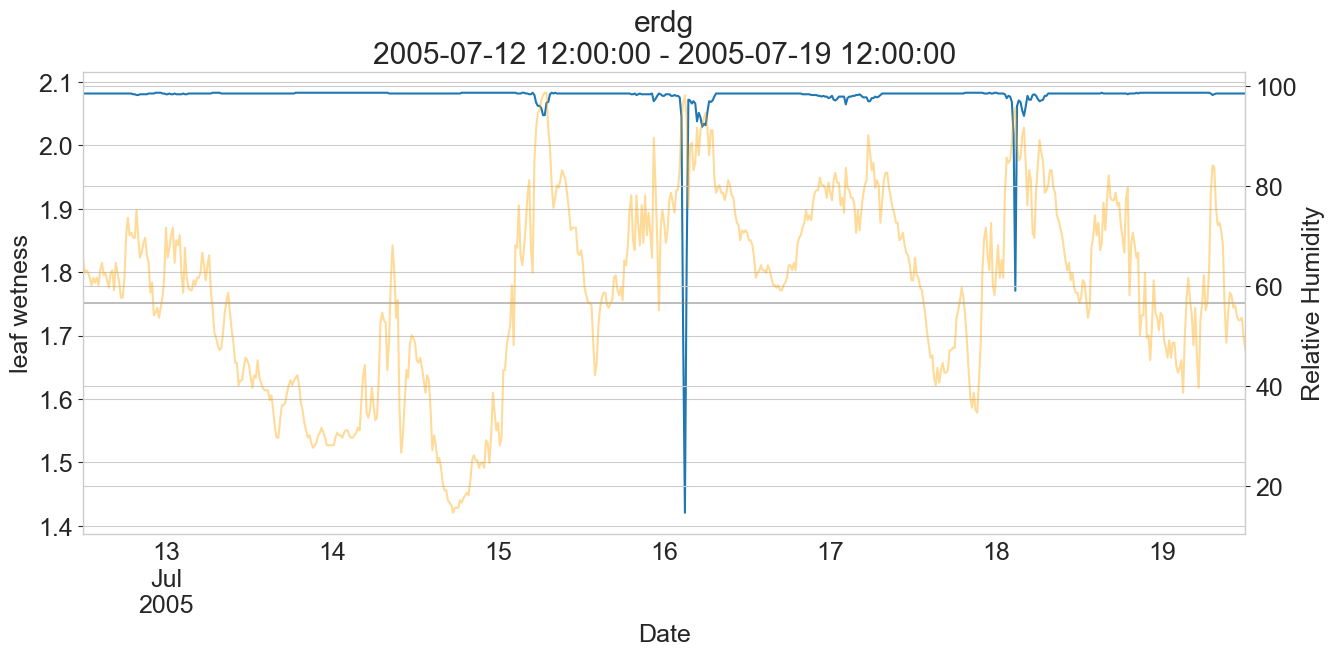

In [222]:
## Other Sites
sites = ['wrdg', 'erdg']
df = met_df.loc[met_df['site'].isin(sites)]
df = df.set_index('time (PST)', drop=False)

# Leaf wetness boxplot
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df,
            y='leaf wetness',
            x='site',
            hue='condition')
plt.title('Leaf Wetness Distribution by Atm Condition')
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.2,1))
plt.show()

# Plot Fog Event Examples
for site in sites:
    fog_event = df.loc[df['site'] == site]['2005-07-12 12:00:00': '2005-07-19 12:00:00']
    leaf_wetness_plot(fog_event, var='leaf wetness')